In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch as T
import pickle
device = T.device("cuda")  # apply to Tensor or Module
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import glob
path = "/mnt/d/Work/Dissertation/Preprocessing/VNIR-Field1/"
#onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
import torch
import struct
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
#from torchvision.transforms import ToTensor
from tqdm import tqdm

/home/han/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
crop_images.shape

NameError: name 'crop_images' is not defined

In [3]:
"""with open("periya_images.pickle","wb") as f:
    pickle.dump(crop_images,f)"""

with open("/mnt/d/Work/Autoenc/hyperspectral-autoencoders-master/hyperspectral-autoencoders-master/autoenc_scratch/periya_images.pickle","rb") as f:
    crop_images=pickle.load(f)
crop_images = torch.tensor(crop_images,dtype=T.float32)
crop_images.to(device)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/Work/Autoenc/hyperspectral-autoencoders-master/hyperspectral-autoencoders-master/autoenc_scratch/periya_images.pickle'

In [4]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [5]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enc1 = T.nn.Conv2d(270, 350, 3)  # 64-16-2-16-64
    self.enc2 = T.nn.Conv2d(350, 420, 3)
    self.enc3 = T.nn.Conv2d(420, 540, 3)
    self.enc4 = T.nn.Conv2d(540, 610, 3)
    self.enc5 = T.nn.Conv2d(610, 760, 3)
    self.pool = T.nn.MaxPool2d(2,stride=2,return_indices=True)
    self.unpool=T.nn.MaxUnpool2d(2,stride=2,padding=0)
    self.dec4 = T.nn.ConvTranspose2d(760, 610, 3)
    self.dec5 = T.nn.ConvTranspose2d(610, 540, 3)
    self.dec6 = T.nn.ConvTranspose2d(540, 420, 3)
    self.dec7 = T.nn.ConvTranspose2d(420, 350, 3)
    self.dec8 = T.nn.ConvTranspose2d(350, 270, 3)

  def encode(self, x):
    z = T.relu(self.enc1(x))
    z,indeces1=self.pool(z)
    z = T.relu(self.enc2(z))
    size1=z.size()
    z,indeces2=self.pool(z)
    z = T.relu(self.enc3(z))
    size2=z.size()
    z,indeces3=self.pool(z)
    z = T.relu(self.enc4(z))
    size3=z.size()
    z,indeces4=self.pool(z)
    z = T.relu(self.enc5(z))
    size4=z.size()
    z,indeces5=self.pool(z)

    return z.to(device),indeces1,indeces2,size1,indeces3,size2,indeces4,size3,indeces5,size4

  def decode(self, x,indeces1,indeces2,size1,indeces3,size2,indeces4,size3,indeces5,size4):
    
    z=self.unpool(x,indeces5,output_size=size4)
    z = self.dec4(z)
    z=self.unpool(z,indeces4,output_size=size3)
    z = self.dec5(z)
    z=self.unpool(z,indeces3,output_size=size2)
    z = self.dec6(z)
    z=self.unpool(z,indeces2,output_size=size1)
    z = self.dec7(z)
    z=self.unpool(z,indeces1)
    z = self.dec8(z)
    return z   

  def forward(self, x):
    
    z,indeces1,indeces2,size1,indeces3,size2,indeces4,size3,indeces5,size4= self.encode(x)
    z = self.decode(z,indeces1,indeces2,size1,indeces3,size2,indeces4,size3,indeces5,size4)
    return z
net=Net().to(device)
inpu=torch.rand(1,270,164,164).to(device)
#out=net.encode(inpu)
out2=net(inpu)
out2.shape


/home/han/.local/lib/python3.8/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


torch.Size([1, 270, 164, 164])

In [14]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 5
train_ldr = T.utils.data.DataLoader(crop_images,
batch_size=bat_size, shuffle=True)
train_ldr
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 2500
ep_log_interval = 10
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = T.nn.L1Loss(reduction='sum')
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0
  for (batch_idx, batch) in loop:
    X = batch.to(device)  # no targets needed

    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, X)  # note: X not Y
    loss_obj1=loss_func1(oupt,X)
    epoch_loss += loss_obj.item()  # accumulate
    mseloss+=loss_obj1.item()
    loss_obj.backward()
    optimizer.step()

    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss),mseloss=str(mseloss))
"""
  if epoch % ep_log_interval == 0:
    print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")"""

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 

bat_size =   5 
loss = L1Loss()
optimizer = Adam
max_epochs = 2500 
lrn_rate = 0.000 

Starting training


Epoch [2499/2500]: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s, loss=1200652.203125, mseloss=0.0011415217450121418]


Creating graph from encoded data 


In [15]:
#torch.save(net.state_dict(), 'hari_model_sample.pth')
torch.save(net, 'hari_model_struct.pth')

In [16]:
oupt.shape,X.shape

(torch.Size([3, 270, 164, 164]), torch.Size([3, 270, 164, 164]))

In [17]:
#net = torch.load('hari_model_struct.pth')
"""net=Net()
net.load_state_dict(torch.load('hari_model_sample.pth'))
net.to(device)"""

"net=Net()\nnet.load_state_dict(torch.load('hari_model_sample.pth'))\nnet.to(device)"

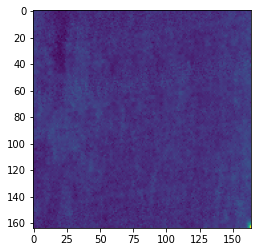

In [18]:
for i in train_ldr:
    break
out=net(i.to(device))
plt.imshow(i[1][0])

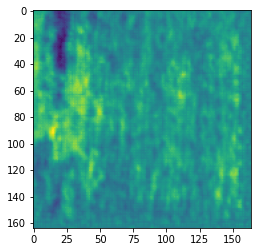

: 

In [28]:
plt.imshow(out[1][0].to("cpu").detach().numpy())

In [24]:
loss_func(out[1][0].to("cpu"), i[1][0].to("cpu"))

tensor(137.2099, grad_fn=<L1LossBackward0>)

In [ ]:
i[0][0]

In [ ]:
out[0][0]

In [ ]:
bow=crop_images.to(device)
xy = net.encode(bow).to(device)
xy = xy.to("cpu").detach().numpy()  

In [ ]:
  with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=crop_images.to(device)
    xy = net.encode(bow)  # (1797,2)
  lbls = train_ds[:]['digit']  # (1797,)
  lbls=lbls.to(device)
  xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
  lbls = lbls.to("cpu").detach().numpy()
  
  

  fig, ax = plt.subplots()
  colors = ['red', 'blue', 'green', 'yellow', 'orange',
            'black', 'brown', 'purple', 'silver', 'pink']
  digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
            ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

  # process by each color/class
  for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
    rows = []                   # select rows for curr color
    for j in range(len(xy)):    # 0 to 1796
      if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
      else:
        rows.append(False)

    rows = np.array(rows, dtype=np.bool)  # list to array
    selected = xy[rows,:]                 # like (178,2)

    x = selected[:,0]  # like (178,)
    y = selected[:,1]
    scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
    # and continue on to next color/class

  txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
    "3=yellow \n" + "4=orange \n" + "5=black \n" + \
    "6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
  ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
    verticalalignment='top', bbox=props)
  ax.grid(True)
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.show()

  print("\nEnd UCI digits auto-reduce-viz demo")


main()

In [ ]:
bow

In [ ]:
train_ds

In [ ]:
train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file)

In [ ]:
main.lbls

In [ ]:
# -----------------------------------------------------------


# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

# 1. create DataLoader object
print("\nCreating UCI Digits Dataset ")

train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file) # all 1797 rows


bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds,
batch_size=bat_size, shuffle=True)

# 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 200
ep_log_interval = 10
lrn_rate = 0.01

loss_func = T.nn.MSELoss()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()
for epoch in range(0, max_epochs):
    epoch_loss = 0  # for one full epoch

    for (batch_idx, batch) in enumerate(train_ldr):
        X = batch['pixels'].to(device)  # no targets needed

        optimizer.zero_grad()
        oupt = net(X)
        loss_obj = loss_func(oupt, X)  # note: X not Y
        epoch_loss += loss_obj.item()  # accumulate
        loss_obj.backward()
        optimizer.step()

    if epoch % ep_log_interval == 0:
        print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()

with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=bow.to(device)
    xy = net.encode(bow)  # (1797,2)
    lbls = train_ds[:]['digit']  # (1797,)
    lbls=lbls.to(device)
    xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
    lbls = lbls.to("cpu").detach().numpy()



fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'yellow', 'orange',
        'black', 'brown', 'purple', 'silver', 'pink']
digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
        ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

# process by each color/class
for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
rows = []                   # select rows for curr color
for j in range(len(xy)):    # 0 to 1796
    if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
    else:
        rows.append(False)

rows = np.array(rows, dtype=np.bool)  # list to array
selected = xy[rows,:]                 # like (178,2)

x = selected[:,0]  # like (178,)
y = selected[:,1]
scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
# and continue on to next color/class

txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
"3=yellow \n" + "4=orange \n" + "5=black \n" + \
"6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
verticalalignment='top', bbox=props)
ax.grid(True)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

print("\nEnd UCI digits auto-reduce-viz demo")


In [ ]:
lbls.shape

In [ ]:
lbls

In [ ]:
xy

In [ ]:
plt.scatter(xy[:,0],xy[:,1])

In [ ]:
xy[:,0].shape

In [ ]:
xy[:,0].shape

In [ ]:
import math
import itertools

target1=8
possible_vals=[]
for i in range(1,target1):
    temp=target1-i
    possible_vals.append(int("".join([str(i),str(temp)])))

for target in possible_vals:
    for i in range(9):
        if(math.factorial(i)>target):
            break
    out1= [math.factorial(bla) for bla in range(1,i)]
    out1
    indeces=[]
    for u in range(i):
        for bla in itertools.combinations(out1,u):
            if(sum(bla)==target):
                indeces.append(bla)
    vals_final=[]
    if(len(indeces)>0):
        for i in indeces:
            for j in i:
                vals_final.append(out1.index(j)+1)

            p= [x for x in itertools.permutations(vals_final,len(vals_final))]
            p1=[int("".join([str(i) for i in ha])) for ha in p]
            print(target,min(p1))

26 24


In [ ]:
indeces

[(2, 6, 24)]

In [ ]:
possible_vals

[14, 23, 32, 41]